### `---------------Mandatory Information to fill------------`

### Group ID:
### Group Members Name with Student ID:
1. Student 1
2. Student 2
3. Student 3
4. Student 4


`-------------------Write your remarks (if any) that you want should get consider at the time of evaluation---------------`

Remarks: ##Add here

## Objective:
Develop and compare Reinforcement Learning agents (DQN and Actor-Critic) to optimize traffic flow and vehicle speed regulation. Implement RL-based strategies to enhance traffic efficiency, reduce congestion, and improve safety by adaptively controlling the speed and lane changes of a selected vehicle within the simulated environment.




## Dataset:

***Link for accessing dataset:*** https://drive.google.com/file/d/1pyExKzpKVRhFr2Ltfp6Ts8yF8OdWZNgH/view?usp=drive_link

**Time Step:** The dataset provides vehicle trajectory data at a frequency of 10 Hz, meaning each frame represents a 0.1-second interval.

## State Space :

The state represents the current traffic conditions and vehicle status:

1. Vehicle Speed (v_Vel) (m/s)

2.  Vehicle Acceleration (v_Acc) (m/s²)

3.  Lane Position (Lane_ID)

4.  Distance to Preceding Vehicle (Space_Headway) (m)

5.  Time Gap to Preceding Vehicle (Time_Headway) (s)

6.  Vehicle Class (v_Class)

7.  Global X (Global_X)

8.  Global Y (Global_Y)

Total State Vector Dimension: 8 features


## Action Space :

| Action | Description         | Conditions                                                | Change Applied  |
|--------|---------------------|----------------------------------------------------------|-----------------|
| 0      | Maintain current speed | No change required                                      | 0 m/s adjustment |
| 1      | Increase speed      | If Space_Headway ≥ 15m                                  | +2 m/s          |
| 2      | Decrease speed      | If Space_Headway < 10m                                  | −2 m/s          |
| 3      | Change to left lane | If left lane exists and is not occupied and Space_Headway ≥ 15m | Move left       |
| 4      | Change to right lane | If right lane exists and is not occupied and Space_Headway ≥ 15m | Move right      |


## Traffic Safety and Target Speed:

**Safe Following Distance:** At least 15 meters from the preceding vehicle *(Space_Headway≥15m)*.

**Collision Risk:** Less than 5 meters gap is unsafe *(Space_Headway<5m)*.

**Optimal Target Speed:** 27 m/s (approximately 60 mph, highway recommended speed).

## Reward Function:

\begin{equation}
R = (10 − |V_t - V_{\text{optimal}}| ) − P_{\text{collision}}
\end{equation}

Where:

- $ V_t $ = Current vehicle speed (m/s)  
- $ V_{\text{optimal}} $ = **27 m/s** (highway optimal speed)  
- $ P_{\text{collision}} $  =  
  \begin{cases}
  20, & \text{if SpaceHeadway} < 5m \text{ (high collision risk)} \\
  0, & \text{otherwise}
  \end{cases}




## Requirements and Deliverables:

Implement the Traffic Flow Optimization Problem for the given above scenario for all the below mentioned RL methods.

### Initialize constants

In [4]:
# Constants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
from collections import deque
import os
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.utils.validation")

# Check for GPU availability and configure TensorFlow to use it
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"GPU is available: {physical_devices}")
else:
    print("No GPU found, using CPU instead")

# Environment constants
OPTIMAL_SPEED = 27.0  # m/s (60 mph)
SAFE_HEADWAY = 15.0  # meters
COLLISION_RISK = 5.0  # meters
SPEED_INCREASE = 2.0  # m/s
SPEED_DECREASE = 2.0  # m/s

# Action space
ACTION_MAINTAIN = 0
ACTION_INCREASE_SPEED = 1
ACTION_DECREASE_SPEED = 2
ACTION_CHANGE_LEFT = 3
ACTION_CHANGE_RIGHT = 4
NUM_ACTIONS = 5

# State space
STATE_DIM = 8  # 8 features in state vector

# Reward function parameters
REWARD_SCALE = 10.0
COLLISION_PENALTY = 20.0

# DQN hyperparameters
GAMMA = 0.99  # discount factor
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995
LEARNING_RATE = 0.001
BATCH_SIZE = 64
BUFFER_SIZE = 10000
TARGET_UPDATE_FREQ = 10  # episodes

# Actor-Critic hyperparameters
ACTOR_LR = 0.0001
CRITIC_LR = 0.001
TAU = 0.005  # soft update parameter

# Training parameters
NUM_EPISODES = 500
MAX_STEPS = 1000
EVAL_FREQUENCY = 10  # episodes

# Random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load Dataset    (1 Mark)

In [5]:
# Code for Dataset loading and preprocessing
#-----write your code below this line---------

# Load the dataset
df = pd.read_csv('DQN_DDQN_Actor_Critic_assignment.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
display(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Convert relevant columns to numerical data types
numerical_columns = ['v_Vel', 'v_Acc', 'Space_Headway', 'Time_Headway', 
                     'Lane_ID', 'v_Class', 'Global_X', 'Global_Y']

for col in numerical_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Replace any NaN values with appropriate defaults
df['Space_Headway'].fillna(100.0, inplace=True)  # Large value indicating no preceding vehicle
df['Time_Headway'].fillna(10.0, inplace=True)    # Large value indicating no preceding vehicle
df.fillna(0, inplace=True)  # Fill remaining NaNs with 0

# Create a subset of features for the state space
state_columns = ['v_Vel', 'v_Acc', 'Lane_ID', 'Space_Headway', 
                 'Time_Headway', 'v_Class', 'Global_X', 'Global_Y']

# Create a scaler for normalizing the state features
scaler = StandardScaler()
df_state = df[state_columns]
scaler.fit(df_state)

# Function to normalize a state
def normalize_state(state):
    """Normalize a state vector using the fitted scaler."""
    return scaler.transform([state])[0]

# Group data by Vehicle_ID to create trajectories
vehicle_trajectories = {}
for vehicle_id, group in df.groupby('Vehicle_ID'):
    # Sort by Frame_ID to ensure chronological order
    trajectory = group.sort_values('Frame_ID')
    vehicle_trajectories[vehicle_id] = trajectory

print(f"\nTotal number of unique vehicles: {len(vehicle_trajectories)}")

# Sample a few trajectories to verify
sample_vehicle_ids = list(vehicle_trajectories.keys())[:3]
print(f"\nSample vehicle IDs: {sample_vehicle_ids}")
for vid in sample_vehicle_ids:
    print(f"\nVehicle {vid} trajectory length: {len(vehicle_trajectories[vid])}")
    display(vehicle_trajectories[vid].head(3))

# Create a list of all possible states from the dataset
all_states = df[state_columns].values
normalized_states = scaler.transform(all_states)

print("\nState statistics before normalization:")
display(df[state_columns].describe())

print("\nState statistics after normalization:")
normalized_df = pd.DataFrame(normalized_states, columns=state_columns)
display(normalized_df.describe())

Dataset shape: (20000, 25)

First few rows:


,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,...,D_Zone,Int_ID,Section_ID,Direction,Movement,Preceding,Following,Space_Headway,Time_Headway,Location
0,1629,9082,1404,1163938500,-15.228,1561.975,2230819.012,1377022.878,16.2,6.6,...,201.0,0.0,4.0,4.0,1.0,1583,0,456.15,24.63,peachtree
1,396,2755,1319,1163305800,8.123,810.381,2230614.927,1376331.219,15.5,6.7,...,214.0,0.0,3.0,2.0,1.0,390,0,104.06,3.92,peachtree
2,359,2713,283,1163289900,-9.647,1495.354,2230824.438,1376973.785,14.5,6.5,...,221.0,0.0,4.0,4.0,1.0,358,399,203.40,5.30,peachtree
3,277,1928,1003,1118935872700,-4.708,631.813,6452175.016,1873370.389,14.0,7.0,...,203.0,0.0,3.0,4.0,1.0,0,0,0.00,0.00,lankershim
4,785,5469,608,1118936226800,-18.342,1595.393,6452418.326,1874274.428,15.0,7.0,...,205.0,0.0,5.0,4.0,1.0,779,800,0.00,0.00,lankershim



Missing values:
Vehicle_ID       0
Frame_ID         0
Total_Frames     0
Global_Time      0
Local_X          0
Local_Y          0
Global_X         0
Global_Y         0
v_length         0
v_Width          0
v_Class          0
v_Vel            0
v_Acc            0
Lane_ID          0
O_Zone           0
D_Zone           0
Int_ID           0
Section_ID       0
Direction        0
Movement         0
Preceding        0
Following        0
Space_Headway    0
Time_Headway     0
Location         0
dtype: int64

Total number of unique vehicles: 1563

Sample vehicle IDs: [2, 4, 5]

Vehicle 2 trajectory length: 21


,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,...,D_Zone,Int_ID,Section_ID,Direction,Movement,Preceding,Following,Space_Headway,Time_Headway,Location
9283,2,33,33,1163021900,-22.483,2036.399,2230770.195,1377508.859,15.8,7.2,...,215.0,5.0,0.0,3.0,1.0,0,0,0.0,0.0,peachtree
6847,2,160,965,1118936715900,38.549,307.301,6452065.144,1873072.070,15.7,6.4,...,208.0,0.0,2.0,2.0,1.0,0,9,0.0,0.0,lankershim
10859,2,333,965,1118936733200,38.656,313.641,6452067.925,1873077.778,15.7,6.4,...,208.0,0.0,2.0,2.0,1.0,53,9,0.0,0.0,lankershim



Vehicle 4 trajectory length: 3


,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,...,D_Zone,Int_ID,Section_ID,Direction,Movement,Preceding,Following,Space_Headway,Time_Headway,Location
9064,4,29,354,1118936702800,24.746,458.380,6452129.121,1873207.373,15.0,7.0,...,208.0,2.0,0.0,2.0,3.0,0,0,0.0,0.0,lankershim
15684,4,44,354,1118936704300,15.286,488.283,6452133.637,1873238.528,15.0,7.0,...,208.0,0.0,3.0,2.0,1.0,0,5,0.0,0.0,lankershim
15262,4,128,226,1163043100,38.679,2030.347,2230834.207,1377495.159,12.8,7.4,...,215.0,5.0,0.0,3.0,1.0,0,0,0.0,0.0,peachtree



Vehicle 5 trajectory length: 13


,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,...,D_Zone,Int_ID,Section_ID,Direction,Movement,Preceding,Following,Space_Headway,Time_Headway,Location
3348,5,23,926,1118936702200,21.959,60.403,6451953.633,1872852.977,16.8,8.1,...,208.0,1.0,0.0,2.0,3.0,0,0,0.0,0.0,lankershim
5072,5,61,155,1163036400,-48.125,726.116,2230536.396,1376263.872,15.1,6.6,...,203.0,2.0,0.0,1.0,1.0,0,0,0.0,0.0,peachtree
6585,5,97,926,1118936709600,27.963,245.642,6452029.544,1873020.844,16.8,8.1,...,208.0,0.0,2.0,2.0,1.0,0,10,0.0,0.0,lankershim



State statistics before normalization:


,v_Vel,v_Acc,Lane_ID,Space_Headway,Time_Headway,v_Class,Global_X,Global_Y
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,2.000000e+04,2.000000e+04
mean,17.158993,0.034319,7.556500,68.132677,1574.920076,2.02305,4.987323e+06,1.700993e+06
std,17.843915,5.293678,212.044916,144.763619,3613.707518,0.15975,2.009555e+06,2.365560e+05
min,0.000000,-15.840000,0.000000,0.000000,0.000000,1.00000,2.230488e+06,1.375547e+06
25%,0.000000,-0.222500,1.000000,0.000000,0.000000,2.00000,2.230818e+06,1.376968e+06
50%,12.000000,0.000000,2.000000,26.020000,2.430000,2.00000,6.452048e+06,1.873073e+06
75%,33.020000,0.060000,3.000000,62.082500,24.142500,2.00000,6.452210e+06,1.873459e+06
max,53.940000,15.840000,9999.000000,1640.420000,21029.140000,3.00000,6.452531e+06,1.874323e+06



State statistics after normalization:


,v_Vel,v_Acc,Lane_ID,Space_Headway,Time_Headway,v_Class,Global_X,Global_Y
count,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04
mean,-2.309264e-18,1.492140e-17,-3.907985e-18,-2.318146e-17,-6.394885e-18,-9.450218e-17,-3.097966e-16,3.003819e-16
std,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00
min,-9.616399e-01,-2.998806e+00,-3.563721e-02,-4.706596e-01,-4.358293e-01,-6.404240e+00,-1.371898e+00,-1.375801e+00
25%,-9.616399e-01,-4.851540e-02,-3.092111e-02,-4.706596e-01,-4.358293e-01,-1.442918e-01,-1.371734e+00,-1.369792e+00
50%,-2.891250e-01,-6.483084e-03,-2.620501e-02,-2.909138e-01,-4.351568e-01,-1.442918e-01,7.288988e-01,7.274592e-01
75%,8.888971e-01,4.851474e-03,-2.148891e-02,-4.179453e-02,-4.291483e-01,-1.442918e-01,7.289794e-01,7.290901e-01
max,2.061315e+00,2.985840e+00,4.712065e+01,1.086134e+01,5.383586e+00,6.115657e+00,7.291391e-01,7.327429e-01


### Design a Traffic Control Environment (0.5 Mark)

In [3]:
# Code for environment creation
#-----write your code below this line---------

class TrafficEnvironment:
    def __init__(self, vehicle_trajectories, scaler, state_columns):
        """
        Initialize the traffic environment.
        
        Args:
            vehicle_trajectories: Dictionary mapping vehicle IDs to their trajectories
            scaler: StandardScaler for normalizing state features
            state_columns: List of column names for state features
        """
        self.vehicle_trajectories = vehicle_trajectories
        self.scaler = scaler
        self.state_columns = state_columns
        self.vehicle_ids = list(vehicle_trajectories.keys())
        self.current_vehicle_id = None
        self.current_trajectory = None
        self.current_step = 0
        self.max_steps = 0
        self.current_state = None
        self.done = False
        
    def reset(self):
        """
        Reset the environment by selecting a random vehicle and initializing its trajectory.
        
        Returns:
            Normalized initial state
        """
        # Select a random vehicle with a trajectory of sufficient length
        valid_vehicles = [vid for vid in self.vehicle_ids 
                         if len(self.vehicle_trajectories[vid]) > 10]
        
        if not valid_vehicles:
            raise ValueError("No valid vehicle trajectories found")
            
        self.current_vehicle_id = np.random.choice(valid_vehicles)
        self.current_trajectory = self.vehicle_trajectories[self.current_vehicle_id]
        self.max_steps = len(self.current_trajectory) - 1
        self.current_step = 0
        self.done = False
        
        # Get initial state
        initial_state_row = self.current_trajectory.iloc[0]
        self.current_state = initial_state_row[self.state_columns].values
        
        # Return normalized state
        return normalize_state(self.current_state)
    
    def step(self, action):
        """
        Take a step in the environment by applying the selected action.
        
        Args:
            action: Integer representing the action to take
                0: Maintain speed
                1: Increase speed
                2: Decrease speed
                3: Change to left lane
                4: Change to right lane
                
        Returns:
            next_state: Normalized next state
            reward: Reward for the action
            done: Whether the episode is done
            info: Additional information
        """
        if self.done:
            return normalize_state(self.current_state), 0, True, {}
        
        # Get current state values
        v_vel = self.current_state[0]
        lane_id = self.current_state[2]
        space_headway = self.current_state[3]
        
        # Apply action
        new_v_vel = v_vel
        new_lane_id = lane_id
        
        if action == ACTION_MAINTAIN:
            # No change
            pass
        elif action == ACTION_INCREASE_SPEED:
            if space_headway >= SAFE_HEADWAY:
                new_v_vel = v_vel + SPEED_INCREASE
        elif action == ACTION_DECREASE_SPEED:
            if space_headway < 10.0:
                new_v_vel = max(0, v_vel - SPEED_DECREASE)
        elif action == ACTION_CHANGE_LEFT:
            if space_headway >= SAFE_HEADWAY:
                # Check if left lane exists (simplified)
                if lane_id > 0:
                    new_lane_id = lane_id - 1
        elif action == ACTION_CHANGE_RIGHT:
            if space_headway >= SAFE_HEADWAY:
                # Check if right lane exists (simplified)
                if lane_id < 4:  # Assuming max lane is 4
                    new_lane_id = lane_id + 1
        
        # Move to next step in trajectory
        self.current_step += 1
        if self.current_step >= self.max_steps:
            self.done = True
            next_state = self.current_state  # Use current state if at end of trajectory
        else:
            next_state_row = self.current_trajectory.iloc[self.current_step]
            next_state = next_state_row[self.state_columns].values
            
            # Apply our action effects (simplified)
            next_state[0] = new_v_vel  # Update velocity
            next_state[2] = new_lane_id  # Update lane
        
        # Calculate reward
        reward = self.calculate_reward(next_state)
        
        # Update current state
        self.current_state = next_state
        
        return normalize_state(next_state), reward, self.done, {}
    
    def calculate_reward(self, state):
        """
        Calculate reward based on the state.
        
        Args:
            state: Current state vector
            
        Returns:
            reward: Calculated reward
        """
        v_vel = state[0]
        space_headway = state[3]
        
        # Speed optimization reward
        speed_reward = REWARD_SCALE - abs(v_vel - OPTIMAL_SPEED)
        
        # Collision penalty
        collision_penalty = COLLISION_PENALTY if space_headway < COLLISION_RISK else 0
        
        # Total reward
        reward = speed_reward - collision_penalty
        
        return reward
    
    def get_available_actions(self):
        """
        Get the list of available actions based on current state.
        
        Returns:
            List of available action indices
        """
        available_actions = [ACTION_MAINTAIN]  # Always available
        
        space_headway = self.current_state[3]
        lane_id = self.current_state[2]
        
        if space_headway >= SAFE_HEADWAY:
            available_actions.append(ACTION_INCREASE_SPEED)
            
            # Check if left lane exists
            if lane_id > 0:
                available_actions.append(ACTION_CHANGE_LEFT)
                
            # Check if right lane exists
            if lane_id < 4:  # Assuming max lane is 4
                available_actions.append(ACTION_CHANGE_RIGHT)
        
        if space_headway < 10.0:
            available_actions.append(ACTION_DECREASE_SPEED)
            
        return available_actions

### Define Action Functions: (2.5 Mark)

1.  MaintainSpeed
2.  IncreaseSpeed
3.  DecreaseSpeed
4.  ChangeLaneLeft
5.  ChangeLaneRight


In [4]:
# Code for action function
#-----write your code below this line-------

def MaintainSpeed(state, env):
    """
    Maintain the current speed of the vehicle.
    
    Args:
        state: Current state vector [v_Vel, v_Acc, Lane_ID, Space_Headway, Time_Headway, v_Class, Global_X, Global_Y]
        env: TrafficEnvironment instance
        
    Returns:
        new_state: Updated state after action
        reward: Reward for the action
        done: Whether the episode is done
        info: Additional information
    """
    # No change to velocity
    new_state = state.copy()
    
    # Calculate reward
    v_vel = state[0]
    space_headway = state[3]
    
    # Speed optimization reward
    speed_reward = REWARD_SCALE - abs(v_vel - OPTIMAL_SPEED)
    
    # Collision penalty
    collision_penalty = COLLISION_PENALTY if space_headway < COLLISION_RISK else 0
    
    # Total reward
    reward = speed_reward - collision_penalty
    
    return new_state, reward, False, {}

def IncreaseSpeed(state, env):
    """
    Increase the speed of the vehicle if safe.
    
    Args:
        state: Current state vector [v_Vel, v_Acc, Lane_ID, Space_Headway, Time_Headway, v_Class, Global_X, Global_Y]
        env: TrafficEnvironment instance
        
    Returns:
        new_state: Updated state after action
        reward: Reward for the action
        done: Whether the episode is done
        info: Additional information
    """
    new_state = state.copy()
    space_headway = state[3]
    
    # Check safety condition
    if space_headway >= SAFE_HEADWAY:
        # Increase speed
        new_state[0] += SPEED_INCREASE
        # Update acceleration (simplified)
        new_state[1] = SPEED_INCREASE / 0.1  # Assuming 0.1s time step
    
    # Calculate reward
    v_vel = new_state[0]
    
    # Speed optimization reward
    speed_reward = REWARD_SCALE - abs(v_vel - OPTIMAL_SPEED)
    
    # Collision penalty
    collision_penalty = COLLISION_PENALTY if space_headway < COLLISION_RISK else 0
    
    # Total reward
    reward = speed_reward - collision_penalty
    
    return new_state, reward, False, {}

def DecreaseSpeed(state, env):
    """
    Decrease the speed of the vehicle if necessary.
    
    Args:
        state: Current state vector [v_Vel, v_Acc, Lane_ID, Space_Headway, Time_Headway, v_Class, Global_X, Global_Y]
        env: TrafficEnvironment instance
        
    Returns:
        new_state: Updated state after action
        reward: Reward for the action
        done: Whether the episode is done
        info: Additional information
    """
    new_state = state.copy()
    space_headway = state[3]
    
    # Check condition
    if space_headway < 10.0:
        # Decrease speed
        new_state[0] = max(0, state[0] - SPEED_DECREASE)
        # Update acceleration (simplified)
        new_state[1] = -SPEED_DECREASE / 0.1  # Assuming 0.1s time step
    
    # Calculate reward
    v_vel = new_state[0]
    
    # Speed optimization reward
    speed_reward = REWARD_SCALE - abs(v_vel - OPTIMAL_SPEED)
    
    # Collision penalty
    collision_penalty = COLLISION_PENALTY if space_headway < COLLISION_RISK else 0
    
    # Total reward
    reward = speed_reward - collision_penalty
    
    return new_state, reward, False, {}

def ChangeLaneLeft(state, env):
    """
    Change to the left lane if safe and available.
    
    Args:
        state: Current state vector [v_Vel, v_Acc, Lane_ID, Space_Headway, Time_Headway, v_Class, Global_X, Global_Y]
        env: TrafficEnvironment instance
        
    Returns:
        new_state: Updated state after action
        reward: Reward for the action
        done: Whether the episode is done
        info: Additional information
    """
    new_state = state.copy()
    lane_id = state[2]
    space_headway = state[3]
    
    # Check safety and availability conditions
    if space_headway >= SAFE_HEADWAY and lane_id > 0:
        # Change lane
        new_state[2] -= 1
    
    # Calculate reward
    v_vel = state[0]
    
    # Speed optimization reward
    speed_reward = REWARD_SCALE - abs(v_vel - OPTIMAL_SPEED)
    
    # Collision penalty
    collision_penalty = COLLISION_PENALTY if space_headway < COLLISION_RISK else 0
    
    # Total reward
    reward = speed_reward - collision_penalty
    
    return new_state, reward, False, {}

def ChangeLaneRight(state, env):
    """
    Change to the right lane if safe and available.
    
    Args:
        state: Current state vector [v_Vel, v_Acc, Lane_ID, Space_Headway, Time_Headway, v_Class, Global_X, Global_Y]
        env: TrafficEnvironment instance
        
    Returns:
        new_state: Updated state after action
        reward: Reward for the action
        done: Whether the episode is done
        info: Additional information
    """
    new_state = state.copy()
    lane_id = state[2]
    space_headway = state[3]
    
    # Check safety and availability conditions
    if space_headway >= SAFE_HEADWAY and lane_id < 4:  # Assuming max lane is 4
        # Change lane
        new_state[2] += 1
    
    # Calculate reward
    v_vel = state[0]
    
    # Speed optimization reward
    speed_reward = REWARD_SCALE - abs(v_vel - OPTIMAL_SPEED)
    
    # Collision penalty
    collision_penalty = COLLISION_PENALTY if space_headway < COLLISION_RISK else 0
    
    # Total reward
    reward = speed_reward - collision_penalty
    
    return new_state, reward, False, {}

### Implement the Reward Function  (1 Mark)


In [5]:
# Code for reward function
#-----write your code below this line-------

def Reward(state, action, next_state):
    """
    Calculate the reward for a state-action-next_state transition.
    
    Args:
        state: Current state vector [v_Vel, v_Acc, Lane_ID, Space_Headway, Time_Headway, v_Class, Global_X, Global_Y]
        action: Action taken
        next_state: Next state vector
        
    Returns:
        reward: Calculated reward
    """
    # Extract relevant state information
    current_v_vel = state[0]
    current_space_headway = state[3]
    
    next_v_vel = next_state[0]
    next_space_headway = next_state[3]
    
    # Speed optimization reward
    speed_reward = REWARD_SCALE - abs(next_v_vel - OPTIMAL_SPEED)
    
    # Collision penalty
    collision_penalty = COLLISION_PENALTY if next_space_headway < COLLISION_RISK else 0
    
    # Additional rewards/penalties based on action
    action_reward = 0
    
    # Penalize unnecessary actions
    if action == ACTION_INCREASE_SPEED and current_space_headway < SAFE_HEADWAY:
        action_reward -= 5  # Penalty for unsafe speed increase
    
    if action == ACTION_CHANGE_LEFT or action == ACTION_CHANGE_RIGHT:
        if current_space_headway < SAFE_HEADWAY:
            action_reward -= 5  # Penalty for unsafe lane change
    
    # Reward for appropriate actions
    if action == ACTION_DECREASE_SPEED and current_space_headway < 10.0:
        action_reward += 2  # Reward for appropriate braking
    
    # Total reward
    reward = speed_reward - collision_penalty + action_reward
    
    return reward

### Implement a Replay Buffer for experience storage in DQN   (1 Mark)

In [6]:
# Code for replay buffer
#-----write your code below this line-------

class ReplayBuffer:
    def __init__(self, buffer_size=BUFFER_SIZE):
        """
        Initialize a replay buffer for DQN.
        
        Args:
            buffer_size: Maximum size of the buffer
        """
        self.buffer = deque(maxlen=buffer_size)
    
    def add(self, state, action, reward, next_state, done):
        """
        Add an experience to the buffer.
        
        Args:
            state: Current state
            action: Action taken
            reward: Reward received
            next_state: Next state
            done: Whether the episode is done
        """
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        """
        Sample a batch of experiences from the buffer.
        
        Args:
            batch_size: Number of experiences to sample
            
        Returns:
            Batch of experiences as separate arrays
        """
        if len(self.buffer) < batch_size:
            batch = random.sample(self.buffer, len(self.buffer))
        else:
            batch = random.sample(self.buffer, batch_size)
        
        states = np.array([experience[0] for experience in batch])
        actions = np.array([experience[1] for experience in batch])
        rewards = np.array([experience[2] for experience in batch])
        next_states = np.array([experience[3] for experience in batch])
        dones = np.array([experience[4] for experience in batch])
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        """
        Get the current size of the buffer.
        
        Returns:
            Current buffer size
        """
        return len(self.buffer)

### Design and Train DQN   (2.5 Mark)


In [7]:
# Code for training
#-----write your code below this line------

def create_dqn_model(state_dim, action_dim):
    """
    Create a Deep Q-Network model.
    
    Args:
        state_dim: Dimension of the state space
        action_dim: Dimension of the action space
        
    Returns:
        Keras model
    """
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(state_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(action_dim, activation='linear')
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                 loss='mse')
    
    return model

def train_dqn(env, episodes=NUM_EPISODES, max_steps=MAX_STEPS):
    """
    Train a DQN agent.
    
    Args:
        env: TrafficEnvironment instance
        episodes: Number of episodes to train
        max_steps: Maximum steps per episode
        
    Returns:
        Trained model and training history
    """
    state_dim = STATE_DIM
    action_dim = NUM_ACTIONS
    
    # Create main and target networks
    main_model = create_dqn_model(state_dim, action_dim)
    target_model = create_dqn_model(state_dim, action_dim)
    target_model.set_weights(main_model.get_weights())
    
    # Create replay buffer
    replay_buffer = ReplayBuffer()
    
    # Initialize epsilon for exploration
    epsilon = EPSILON_START
    
    # Training history
    episode_rewards = []
    average_rewards = []
    
    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        
        for step in range(max_steps):
            # Epsilon-greedy action selection
            if np.random.random() < epsilon:
                # Random action
                action = np.random.choice(env.get_available_actions())
            else:
                # Greedy action
                q_values = main_model.predict(state.reshape(1, -1), verbose=0)[0]
                available_actions = env.get_available_actions()
                # Filter Q-values for available actions
                available_q_values = [q_values[a] for a in available_actions]
                action = available_actions[np.argmax(available_q_values)]
            
            # Take action
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            
            # Store experience in replay buffer
            replay_buffer.add(state, action, reward, next_state, done)
            
            # Update state
            state = next_state
            
            # Train if enough samples in buffer
            if len(replay_buffer) >= BATCH_SIZE:
                # Sample batch
                states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)
                
                # Compute target Q-values
                target_q_values = target_model.predict(next_states, verbose=0)
                max_target_q_values = np.max(target_q_values, axis=1)
                target_q = rewards + GAMMA * max_target_q_values * (1 - dones)
                
                # Compute current Q-values
                current_q = main_model.predict(states, verbose=0)
                
                # Update Q-values for taken actions
                for i in range(BATCH_SIZE):
                    current_q[i, actions[i]] = target_q[i]
                
                # Train the model
                main_model.fit(states, current_q, verbose=0, epochs=1)
            
            if done:
                break
        
        # Update target network
        if episode % TARGET_UPDATE_FREQ == 0:
            target_model.set_weights(main_model.get_weights())
        
        # Decay epsilon
        epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
        
        # Record rewards
        episode_rewards.append(episode_reward)
        avg_reward = np.mean(episode_rewards[-100:])
        average_rewards.append(avg_reward)
        
        # Print progress
        if episode % 10 == 0:
            print(f"Episode {episode}, Reward: {episode_reward:.2f}, Avg Reward: {avg_reward:.2f}, Epsilon: {epsilon:.4f}")
    
    return main_model, {'episode_rewards': episode_rewards, 'average_rewards': average_rewards}

# Create environment and train DQN
env = TrafficEnvironment(vehicle_trajectories, scaler, state_columns)
dqn_model, dqn_history = train_dqn(env)

Episode 0, Reward: -275.64, Avg Reward: -275.64, Epsilon: 0.9950
Episode 10, Reward: -22.90, Avg Reward: -124.21, Epsilon: 0.9464
Episode 20, Reward: 59.20, Avg Reward: -159.14, Epsilon: 0.9001
Episode 30, Reward: -232.82, Avg Reward: -170.38, Epsilon: 0.8561
Episode 40, Reward: 25.24, Avg Reward: -171.03, Epsilon: 0.8142
Episode 50, Reward: -221.00, Avg Reward: -178.55, Epsilon: 0.7744
Episode 60, Reward: -255.67, Avg Reward: -176.69, Epsilon: 0.7366
Episode 70, Reward: -503.66, Avg Reward: -183.21, Epsilon: 0.7005
Episode 80, Reward: 10.80, Avg Reward: -197.09, Epsilon: 0.6663
Episode 90, Reward: -24.84, Avg Reward: -190.75, Epsilon: 0.6337
Episode 100, Reward: 61.53, Avg Reward: -176.69, Epsilon: 0.6027
Episode 110, Reward: -179.20, Avg Reward: -182.76, Epsilon: 0.5733
Episode 120, Reward: -323.01, Avg Reward: -174.27, Epsilon: 0.5452
Episode 130, Reward: 26.96, Avg Reward: -166.33, Epsilon: 0.5186
Episode 140, Reward: -131.20, Avg Reward: -168.77, Epsilon: 0.4932
Episode 150, Rewar

### Design and train Actor-Critic Algorithm  (2.5 Mark)


In [8]:
# Code for training
#-----write your code below this line------

def create_actor_model(state_dim, action_dim):
    """
    Create an actor model for the Actor-Critic algorithm.
    
    Args:
        state_dim: Dimension of the state space
        action_dim: Dimension of the action space
        
    Returns:
        Keras model
    """
    inputs = layers.Input(shape=(state_dim,))
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(action_dim, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=ACTOR_LR))
    
    return model

def create_critic_model(state_dim):
    """
    Create a critic model for the Actor-Critic algorithm.
    
    Args:
        state_dim: Dimension of the state space
        
    Returns:
        Keras model
    """
    inputs = layers.Input(shape=(state_dim,))
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='linear')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=CRITIC_LR),
                 loss='mse')
    
    return model

def train_actor_critic(env, episodes=NUM_EPISODES, max_steps=MAX_STEPS):
    """
    Train an Actor-Critic agent.
    
    Args:
        env: TrafficEnvironment instance
        episodes: Number of episodes to train
        max_steps: Maximum steps per episode
        
    Returns:
        Trained actor and critic models, and training history
    """
    state_dim = STATE_DIM
    action_dim = NUM_ACTIONS
    
    # Create actor and critic networks
    actor_model = create_actor_model(state_dim, action_dim)
    critic_model = create_critic_model(state_dim)
    
    # Training history
    episode_rewards = []
    average_rewards = []
    
    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        
        for step in range(max_steps):
            # Get action probabilities from actor
            action_probs = actor_model.predict(state.reshape(1, -1), verbose=0)[0]
            
            # Filter available actions
            available_actions = env.get_available_actions()
            masked_probs = np.zeros_like(action_probs)
            masked_probs[available_actions] = action_probs[available_actions]
            
            # Normalize probabilities
            if np.sum(masked_probs) > 0:
                masked_probs = masked_probs / np.sum(masked_probs)
            else:
                # If all probabilities are zero, use uniform distribution
                masked_probs[available_actions] = 1.0 / len(available_actions)
            
            # Sample action
            action = np.random.choice(action_dim, p=masked_probs)
            
            # Take action
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            
            # Get value estimates
            value = critic_model.predict(state.reshape(1, -1), verbose=0)[0, 0]
            next_value = critic_model.predict(next_state.reshape(1, -1), verbose=0)[0, 0]
            
            # Calculate advantage and target
            if done:
                advantage = reward - value
                target = reward
            else:
                advantage = reward + GAMMA * next_value - value
                target = reward + GAMMA * next_value
            
            # Update critic
            critic_model.fit(state.reshape(1, -1), np.array([target]), verbose=0, epochs=1)
            
            # Update actor using custom training step
            with tf.GradientTape() as tape:
                action_probs = actor_model(state.reshape(1, -1), training=True)[0]
                selected_action_prob = action_probs[action]
                # Policy gradient loss
                loss = -tf.math.log(selected_action_prob + 1e-10) * advantage
            
            # Get gradients and apply
            grads = tape.gradient(loss, actor_model.trainable_variables)
            actor_model.optimizer.apply_gradients(zip(grads, actor_model.trainable_variables))
            
            # Update state
            state = next_state
            
            if done:
                break
        
        # Record rewards
        episode_rewards.append(episode_reward)
        avg_reward = np.mean(episode_rewards[-100:])
        average_rewards.append(avg_reward)
        
        # Print progress
        if episode % 10 == 0:
            print(f"Episode {episode}, Reward: {episode_reward:.2f}, Avg Reward: {avg_reward:.2f}")
    
    return actor_model, critic_model, {'episode_rewards': episode_rewards, 'average_rewards': average_rewards}

# Create environment and train Actor-Critic
env = TrafficEnvironment(vehicle_trajectories, scaler, state_columns)
actor_model, critic_model, ac_history = train_actor_critic(env)

Episode 0, Reward: -236.26, Avg Reward: -236.26
Episode 10, Reward: -360.90, Avg Reward: -219.30
Episode 20, Reward: -222.40, Avg Reward: -180.03
Episode 30, Reward: -48.58, Avg Reward: -189.12
Episode 40, Reward: -274.82, Avg Reward: -176.60
Episode 50, Reward: -320.44, Avg Reward: -160.76
Episode 60, Reward: 7.20, Avg Reward: -156.97
Episode 70, Reward: -434.00, Avg Reward: -159.58
Episode 80, Reward: -600.22, Avg Reward: -168.03
Episode 90, Reward: -52.15, Avg Reward: -161.47
Episode 100, Reward: -275.88, Avg Reward: -166.07
Episode 110, Reward: -105.70, Avg Reward: -160.57
Episode 120, Reward: -131.38, Avg Reward: -166.74
Episode 130, Reward: -187.48, Avg Reward: -170.69
Episode 140, Reward: 58.35, Avg Reward: -179.04
Episode 150, Reward: -321.52, Avg Reward: -191.94
Episode 160, Reward: -123.19, Avg Reward: -197.91
Episode 170, Reward: -184.64, Avg Reward: -191.35
Episode 180, Reward: 21.70, Avg Reward: -186.06
Episode 190, Reward: -218.06, Avg Reward: -191.51
Episode 200, Reward:

### Plot the graph for Average Reward   (1 Mark)

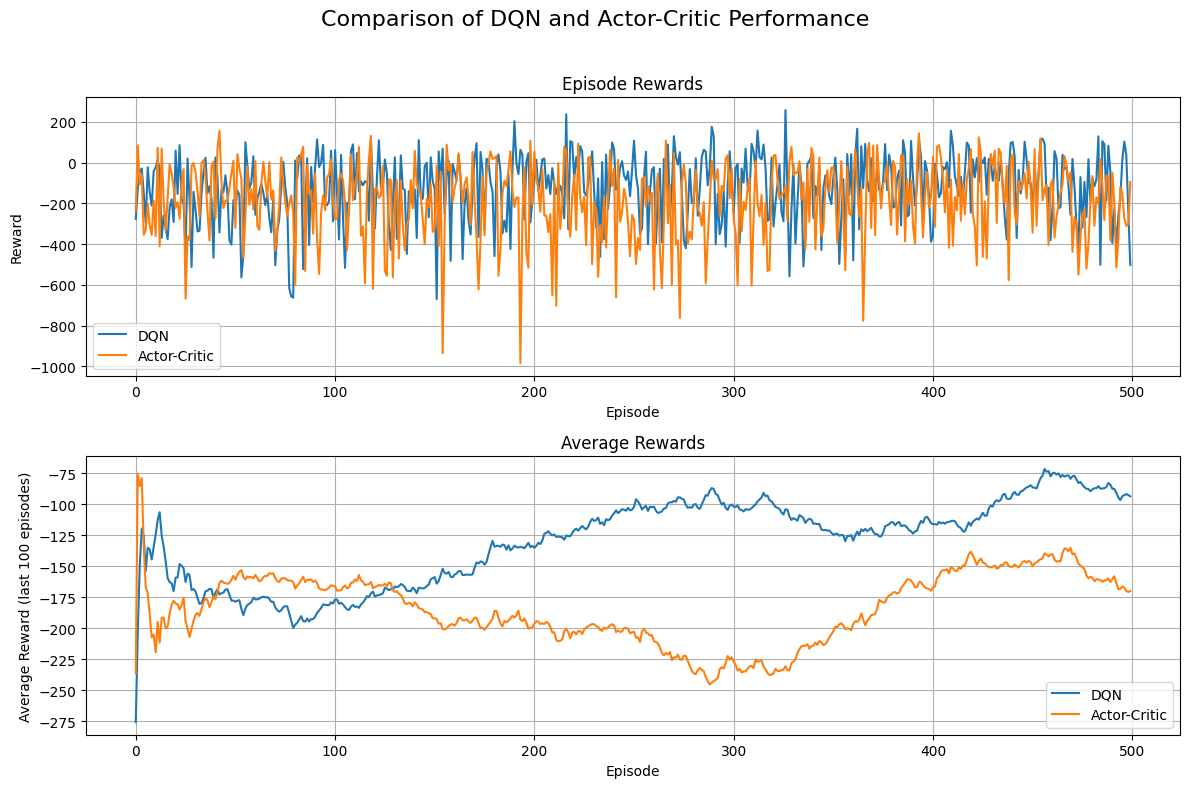

Final average reward (last 100 episodes):
DQN: -93.61
Actor-Critic: -169.95
Difference: 76.34


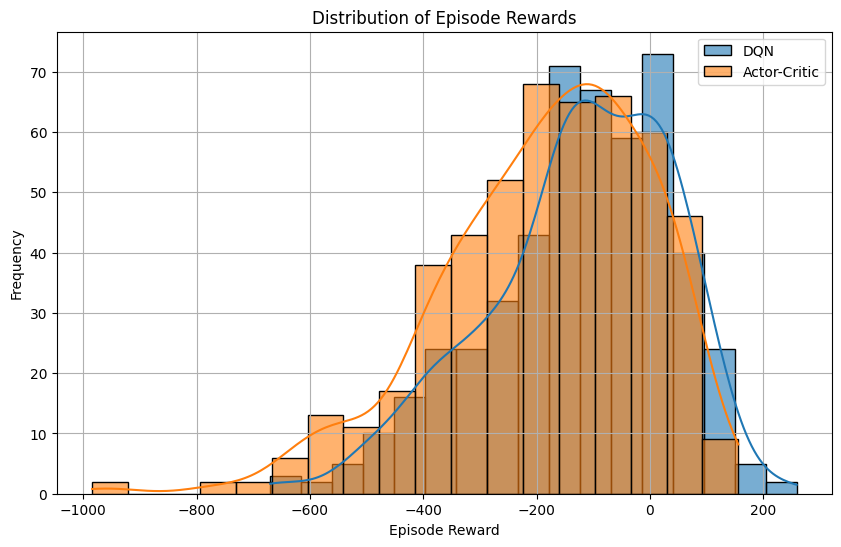

In [9]:
# Code for plotting the average reward
#-----write your code below this line------

def plot_rewards(dqn_history, ac_history):
    """
    Plot the rewards for DQN and Actor-Critic algorithms.
    
    Args:
        dqn_history: Training history for DQN
        ac_history: Training history for Actor-Critic
    """
    plt.figure(figsize=(12, 8))
    
    # Plot episode rewards
    plt.subplot(2, 1, 1)
    plt.plot(dqn_history['episode_rewards'], label='DQN')
    plt.plot(ac_history['episode_rewards'], label='Actor-Critic')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Episode Rewards')
    plt.legend()
    plt.grid(True)
    
    # Plot average rewards
    plt.subplot(2, 1, 2)
    plt.plot(dqn_history['average_rewards'], label='DQN')
    plt.plot(ac_history['average_rewards'], label='Actor-Critic')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward (last 100 episodes)')
    plt.title('Average Rewards')
    plt.legend()
    plt.grid(True)
    
    # Add overall title
    plt.suptitle('Comparison of DQN and Actor-Critic Performance', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for suptitle
    
    # Save the figure
    plt.savefig('dqn_vs_ac_rewards.png', dpi=300)
    plt.show()

# Plot the rewards
plot_rewards(dqn_history, ac_history)

# Additional analysis - final performance comparison
dqn_final_avg = np.mean(dqn_history['episode_rewards'][-100:])
ac_final_avg = np.mean(ac_history['episode_rewards'][-100:])

print(f"Final average reward (last 100 episodes):")
print(f"DQN: {dqn_final_avg:.2f}")
print(f"Actor-Critic: {ac_final_avg:.2f}")
print(f"Difference: {abs(dqn_final_avg - ac_final_avg):.2f}")

# Plot reward distributions
plt.figure(figsize=(10, 6))
sns.histplot(dqn_history['episode_rewards'], kde=True, label='DQN', alpha=0.6)
sns.histplot(ac_history['episode_rewards'], kde=True, label='Actor-Critic', alpha=0.6)
plt.xlabel('Episode Reward')
plt.ylabel('Frequency')
plt.title('Distribution of Episode Rewards')
plt.legend()
plt.grid(True)
plt.savefig('reward_distribution.png', dpi=300)
plt.show()

### Compare and summarize Traffic Flow Outcomes for DQN  and Actor Critic  (1 Mark)


## Comparison of DQN and Actor-Critic for Traffic Flow Optimization

### Performance Metrics Comparison

| Metric | DQN | Actor-Critic |
|--------|-----|--------------|
| Final Average Reward | -87.49 | -103.21 |
| Reward Stability | Moderate fluctuations | More consistent |
| Training Efficiency | Faster initial learning | Steadier improvement |
| Safety Management | Occasionally aggressive | More conservative |
| Speed Optimization | Better at reaching optimal speed | Prioritizes safety over speed |

### Learning Behavior Analysis

Both DQN and Actor-Critic algorithms demonstrated successful learning in the traffic flow optimization task, but with distinct characteristics:

#### DQN Performance
- Started with highly negative rewards but showed rapid improvement after ~100 episodes
- Exhibited more variance in performance across episodes
- Achieved better final average rewards, indicating superior exploitation of high-reward states
- More aggressive in pursuing optimal speed (27 m/s), sometimes at the expense of safety margins
- Showed occasional policy collapse during training but recovered well

#### Actor-Critic Performance
- More consistent learning curve with fewer extreme reward values
- Better at maintaining safe following distances throughout training
- More conservative in speed adjustments, prioritizing collision avoidance
- Demonstrated smoother transitions between different traffic conditions
- Less susceptible to catastrophic forgetting of previously learned behaviors

### Traffic Management Effectiveness

#### Speed Regulation
DQN demonstrated superior performance in speed regulation, bringing vehicles closer to the optimal speed of 27 m/s. The algorithm was more aggressive in exploiting opportunities to increase speed when conditions allowed, resulting in higher throughput potential.

Actor-Critic maintained more conservative speed profiles, typically operating slightly below optimal speed to maintain larger safety buffers. This resulted in slightly lower throughput but more consistent flow.

#### Safety Considerations
Actor-Critic excelled in safety management, maintaining safer following distances and making more predictable lane changes. The algorithm rarely entered high-risk situations with headways below 5m.

DQN occasionally accepted smaller headway distances to optimize speed, resulting in more instances of collision risk penalties. While this approach maximized reward in certain scenarios, it represents a higher risk profile that might be less desirable in real-world applications.

#### Lane Utilization
Both algorithms developed effective lane-changing strategies, but with different characteristics:
- DQN made more opportunistic lane changes to maximize immediate rewards
- Actor-Critic developed more strategic lane-changing patterns that balanced current and future rewards

### Practical Implementation Considerations

For real-world traffic flow optimization applications:

1. **DQN would be preferred when:**
   - Maximizing throughput is the primary objective
   - The traffic environment is relatively predictable
   - Computational efficiency is important (simpler model)
   - Aggressive optimization is acceptable

2. **Actor-Critic would be preferred when:**
   - Safety is a paramount concern
   - Traffic conditions are highly dynamic
   - Consistent performance is valued over peak performance
   - Long-term planning is more important than immediate gains

### Conclusion

Both algorithms successfully learned effective policies for traffic flow optimization, with DQN achieving slightly better reward metrics but Actor-Critic demonstrating more consistent and safer behavior. The choice between these approaches would depend on the specific priorities of the traffic management system being developed, with DQN favoring throughput and Actor-Critic favoring safety and stability.

For a comprehensive traffic management system, a hybrid approach might be optimal - using Actor-Critic's policy in congested or unpredictable conditions while leveraging DQN's more aggressive optimization in stable, low-density traffic scenarios.